# Revised Quantitative Backtesting Framework

## Key Changes based on Supervisor Feedback:
1.  **New Backtesting Logic (`run_backtest_independent_trades`):**
    - **Simple Interest:** Strategy PnL is calculated by summing the returns of individual trades, without compounding profits.
    - **Independent Trades:** Each signal initiates a distinct trade, allowing for overlapping positions.
    - **Fixed Holding Period:** A trade opened at time `T` is now closed exactly 10 periods later at `T+10`.
2.  **Data Source:** The script now uses the supervisor-provided data (`_test_backtest_intern.pkl`), which contains pre-computed signals. The model training part is no longer needed.
3.  **Supervisor's Sanity Check:** Added a correlation calculation between the strategy's cumulative PnL and a benchmark `(signal * return).cumsum()` for direct comparison.
4.  **Simplified Evaluation:** The performance evaluation function is adapted to the new backtesting model and no longer includes factor analysis.

In [16]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style
from pathlib import Path

---
## 1. 日志和绘图设置

In [17]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # Use a visually appealing plotting style

---
## 2. 核心回测与评估函数 (源于您的代码)

In [18]:
def run_backtest_independent_trades(prices, signals, holding_period=10, initial_capital=100000, commission_rate=0.0002):
    """
    Executes a backtest based on independent trades with a fixed holding period and simple interest.

    This logic addresses the supervisor's feedback:
    - Each signal creates a trade from T to T+10.
    - Trades are independent and can overlap.
    - PnL is summed without compounding (simple interest).

    Parameters:
    - prices (pd.Series): 'close' price series.
    - signals (pd.Series): Trading signals (1 for long, -1 for short, 0 for neutral).
    - holding_period (int): The number of periods to hold a position.
    - initial_capital (float): Starting capital.
    - commission_rate (float): Transaction commission rate per trade (one side).

    Returns:
    - pd.DataFrame: A DataFrame with detailed backtest results (equity curve, PnL, etc.).
    - pd.DataFrame: A DataFrame containing details of every single trade executed.
    """
    logging.info(f"🤔 Running backtest with independent trades and a {holding_period}-period hold...")

    # --- 1. Data Preparation ---
    df = pd.DataFrame({'close': prices, 'signal': signals}).sort_index()
    df['market_return'] = df['close'].pct_change()

    # --- 2. Generate Individual Trades ---
    trade_list = []
    # The signal at time t-1 triggers a trade at time t. shift(1) aligns this.
    trade_triggers = df['signal'].shift(1)
    # Filter for actual trade signals (non-zero)
    entry_signals = trade_triggers[trade_triggers != 0]

    logging.info(f"Found {len(entry_signals)} potential trade triggers.")

    for entry_time, direction in entry_signals.items():
        try:
            # Find the integer index location of the entry_time
            entry_idx = df.index.get_loc(entry_time)
            # Calculate exit index
            exit_idx = entry_idx + holding_period

            # Ensure the exit time is within the data's bounds
            if exit_idx < len(df.index):
                exit_time = df.index[exit_idx]

                entry_price = df.loc[entry_time, 'close']
                exit_price = df.loc[exit_time, 'close']

                # --- Calculate PnL for this single trade ---
                # Gross return based on price change
                trade_return = direction * ((exit_price / entry_price) - 1)
                # Commission for a round trip (entry + exit)
                commission = 2 * commission_rate
                # Net return after costs
                net_return = trade_return - commission

                trade_list.append({
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'direction': direction,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'gross_return': trade_return,
                    'net_return': net_return
                })
        except KeyError:
            # This can happen if the first signal is at the very start of the dataframe
            logging.warning(f"Could not find entry time {entry_time} in index. Skipping trade.")
            continue

    if not trade_list:
        logging.error("❌ No trades were successfully generated. Cannot proceed.")
        return pd.DataFrame(), pd.DataFrame()

    trades_df = pd.DataFrame(trade_list)
    logging.info(f"Successfully generated {len(trades_df)} trades.")

    # --- 3. Calculate PnL Series and Equity Curve (Simple Interest) ---
    # Group trades by their exit time and sum the PnL. This creates a series of realized PnL.
    pnl_by_exit_time = trades_df.groupby('exit_time')['net_return'].sum()

    # Create a full PnL series with zeros for timestamps with no exiting trades
    daily_pnl = pd.Series(0.0, index=df.index)
    daily_pnl.update(pnl_by_exit_time)

    # Calculate the equity curve using simple interest (cumulative sum of PnL)
    cumulative_pnl = daily_pnl.cumsum()
    equity_curve = initial_capital * (1 + cumulative_pnl)

    # --- 4. Assemble Final Results ---
    backtest_results = df.copy()
    backtest_results['daily_pnl'] = daily_pnl
    backtest_results['cumulative_pnl'] = cumulative_pnl
    backtest_results['equity_curve'] = equity_curve
    # Add columns for compatibility with the evaluation function
    backtest_results['strategy_net_returns'] = daily_pnl
    backtest_results['market_returns'] = df['market_return']

    # Calculate the number of overlapping active trades at any given time
    active_positions = pd.Series(0, index=df.index)
    for _, trade in trades_df.iterrows():
        # Increment the counter for the duration of the trade
        active_positions.loc[trade['entry_time']:trade['exit_time']] += 1
    backtest_results['active_trades'] = active_positions
    # The 'position' column can represent the net directional exposure
    net_exposure = pd.Series(0.0, index=df.index)
    for _, trade in trades_df.iterrows():
        net_exposure.loc[trade['entry_time']:trade['exit_time']] += trade['direction']
    backtest_results['position'] = net_exposure


    logging.info("🎉🎉 Vectorized backtest complete.")
    return backtest_results, trades_df

In [19]:
def evaluate_performance(backtest_results, trades_df, evaluation_criteria, initial_capital):
    """
    Calculates and displays a comprehensive performance evaluation report.
    Adapted to work with the output of the new independent trades backtest.
    """
    logging.info("🤔🤔🤔 Starting strategy performance evaluation...")

    if backtest_results.empty or trades_df.empty:
        logging.error("❌ Backtest results are empty. Cannot evaluate performance.")
        return

    equity_curve = backtest_results['equity_curve'].dropna()
    net_returns = backtest_results['strategy_net_returns'] # This is now the daily PnL factor
    market_returns = backtest_results['market_returns']
    
    # --- 1. Trade Statistics (from trades_df) ---
    trade_returns_series = trades_df['net_return']
    
    winning_trades_pnl = trade_returns_series[trade_returns_series > 0]
    losing_trades_pnl = trade_returns_series[trade_returns_series <= 0]
    
    total_trades = len(trades_df)
    num_winning_trades = len(winning_trades_pnl)
    num_losing_trades = len(losing_trades_pnl)
    
    win_rate = num_winning_trades / total_trades if total_trades > 0 else 0
    
    total_profit_amount_trades = winning_trades_pnl.sum()
    total_loss_amount_trades = abs(losing_trades_pnl.sum())
    
    profit_loss_ratio = total_profit_amount_trades / total_loss_amount_trades if total_loss_amount_trades > 0 else np.inf
    
    expectancy = (win_rate * profit_loss_ratio) - (1 - win_rate) if win_rate > 0 and profit_loss_ratio != np.inf else -1

    # --- 2. Core Metrics (from equity_curve and PnL series) ---
    annualization_factor = 12 # Based on monthly resampling

    total_days = (equity_curve.index[-1] - equity_curve.index[0]).days if len(equity_curve) > 1 else 0
    duration_years = total_days / 365.0 if total_days > 0 else 1

    total_return = (equity_curve.iloc[-1] / initial_capital) - 1 if initial_capital != 0 else 0
    
    annualized_return = total_return / duration_years

    # --- 【代码修正处】---
    # 错误原因: .resample('M') 返回一个 Resampler 对象, 不能直接进行数学运算。
    # 修正方法: 必须先对 Resampler 对象调用一个聚合函数 (如 .sum(), .mean())。
    #           根据简单利息的逻辑，月度收益应为每日收益之和，故使用 .sum()。
    #           另外，net_returns 本身就是收益率，求和后无需再减 1。
    monthly_net_returns = net_returns.resample('M').sum()
    monthly_net_returns = monthly_net_returns.dropna()
    
    monthly_market_returns = (1 + market_returns).resample('M').prod() - 1
    monthly_market_returns = monthly_market_returns.dropna()

    annualized_volatility = monthly_net_returns.std() * np.sqrt(annualization_factor) if not monthly_net_returns.empty else 0

    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max
    max_drawdown = abs(drawdown.min())
    
    end_date_idx = drawdown.idxmin() if not drawdown.empty else None
    peak_idx = equity_curve.loc[:end_date_idx].idxmax() if end_date_idx is not None else None

    # 计算夏普比率时，月均收益率的无风险利率假定为0
    sharpe_ratio = (monthly_net_returns.mean() / monthly_net_returns.std()) * np.sqrt(annualization_factor) if annualized_volatility > 0 else 0

    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else 0

    downside_monthly_returns = monthly_net_returns[monthly_net_returns < 0]
    downside_std = downside_monthly_returns.std() if not downside_monthly_returns.empty else 0
    # 计算索提诺比率时，月均收益率的无风险利率假定为0
    sortino_ratio = (monthly_net_returns.mean() / downside_std) * np.sqrt(annualization_factor) if downside_std > 0 else 0

    average_win = winning_trades_pnl.mean() if num_winning_trades > 0 else 0
    average_loss = abs(losing_trades_pnl.mean()) if num_losing_trades > 0 else 0
    
    total_pnl_amount = equity_curve.iloc[-1] - initial_capital

    annual_returns = (1 + net_returns).resample('Y').prod() - 1
    annual_returns.index = annual_returns.index.year

    # --- 3. Other Metrics ---
    total_weeks = total_days / 7.0 if total_days > 0 else 1
    weekly_trade_frequency = total_trades / total_weeks if total_weeks > 0 else 0

    # Turnover Calculation
    # Total value traded is the sum of all entry prices (assuming fixed capital per trade)
    # Since it's simple interest, we assume each trade uses a notional capital of 1 unit.
    # The PnL is a factor. Total PnL is sum of these factors.
    # A simple turnover metric: number of trades per year.
    annualized_turnover = total_trades / duration_years if duration_years > 0 else 0

    # --- 4. Print Evaluation Report ---
    print("\n" + "="*80)
    print(Fore.CYAN + Style.BRIGHT + " " * 30 + "Strategy Performance Report" + " " * 30 + Style.RESET_ALL)
    print("="*80)
    
    def format_check(name, value, req_value, req_prefix, comp_func):
        is_ok = comp_func(value, req_value)
        status = "✅ Pass" if is_ok else "❌ Fail"
        req_str = f"{req_prefix} {req_value:.2f}"
        color = Fore.GREEN if is_ok else Fore.RED
        return [name, f"{value:.4f}", req_str, color + status + Style.RESET_ALL]

    headers = ["Metric", "Result", "Requirement", "Status"]
    profit_table = [
        format_check("Sharpe Ratio", sharpe_ratio, evaluation_criteria['sharpe_ratio'], ">", lambda v, r: v > r),
        format_check("Calmar Ratio", calmar_ratio, evaluation_criteria['calmar_ratio'], ">", lambda v, r: v > r),
        format_check("Expectancy", expectancy, evaluation_criteria['expectancy'], ">", lambda v, r: v > r)
    ]
    print("\n" + Fore.BLUE + Style.BRIGHT + "--- Profitability Metrics ---" + Style.RESET_ALL)
    print(tabulate(profit_table, headers=headers, tablefmt="grid", stralign="center"))

    risk_table = [
        format_check("Max Drawdown (MDD)", max_drawdown, evaluation_criteria['max_drawdown'], "<", lambda v, r: v < r),
        format_check("Weekly Trade Freq.", weekly_trade_frequency, evaluation_criteria['weekly_frequency'], ">", lambda v, r: v > r)
    ]
    print("\n" + Fore.YELLOW + Style.BRIGHT + "--- Risk & Efficiency Metrics ---" + Style.RESET_ALL)
    print(tabulate(risk_table, headers=headers, tablefmt="grid", stralign="center"))

    # Detailed stats
    print("\n" + Fore.GREEN + Style.BRIGHT + "--- Detailed Statistics ---" + Style.RESET_ALL)
    detail_headers = ["Metric", "Value"]
    detail_table = [
        ["Total Return", f"{total_return:.2%}"],
        ["Annualized Return", f"{annualized_return:.2%}"],
        ["Annualized Volatility", f"{annualized_volatility:.2%}"],
        ["Sortino Ratio", f"{sortino_ratio:.4f}"],
        ["Total PnL", f"{total_pnl_amount:,.2f}"],
        ["Total Trades", f"{total_trades}"],
        ["Win Rate", f"{win_rate:.2%}"],
        ["Profit/Loss Ratio", f"{profit_loss_ratio:.2f}"],
        ["Average Win", f"{average_win:.4%}"],
        ["Average Loss", f"{average_loss:.4%}"],
        ["Annualized Turnover (Trades/Year)", f"{annualized_turnover:.2f}"],
        ["MDD Start Date", str(peak_idx.date()) if peak_idx else "N/A"],
        ["MDD End Date", str(end_date_idx.date()) if end_date_idx else "N/A"]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center"))

    # Annual returns
    print("\n" + Fore.MAGENTA + Style.BRIGHT + "--- Annual Returns ---" + Style.RESET_ALL)
    annual_returns_df = annual_returns.reset_index()
    annual_returns_df.columns = ["Year", "Return"]
    annual_returns_df["Return"] = annual_returns_df["Return"].apply(lambda x: f"{x:.2%}")
    print(tabulate(annual_returns_df, headers="keys", tablefmt="grid", stralign="center", showindex=False))

    # --- 5. Plot Equity Curve ---
    fig, ax1 = plt.subplots(figsize=(20, 10))
    
    # Plot Strategy Equity
    equity_curve.plot(label='Strategy Equity (Simple Interest)', lw=2, color='royalblue', ax=ax1)
    
    # Plot Buy & Hold Benchmark
    benchmark_equity = initial_capital * (1 + market_returns).cumprod()
    benchmark_equity.plot(label='Buy & Hold Benchmark', lw=2, linestyle='--', color='darkorange', ax=ax1)

    ax1.set_title('Strategy vs. Buy & Hold Equity Curves', fontsize=16)
    ax1.set_ylabel('Equity', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    logging.info("🎊🎊🎊 Strategy evaluation complete 🎊🎊🎊")

---
## 3. 主程序执行

2025-07-23 22:57:12,603 - INFO - Loading data from /public/data/_test_backtest_intern.pkl...
2025-07-23 22:57:12,605 - INFO - ✅ Data loaded successfully.
2025-07-23 22:57:12,605 - INFO - Data shape: (131808, 2)
2025-07-23 22:57:12,606 - INFO - Time range: 2021-09-27 00:00:00 to 2025-06-30 23:45:00
2025-07-23 22:57:12,607 - INFO - 🤔 Running backtest with independent trades and a 10-period hold...
2025-07-23 22:57:12,611 - INFO - Found 26862 potential trade triggers.
2025-07-23 22:57:13,463 - INFO - Successfully generated 26858 trades.
2025-07-23 22:57:27,470 - INFO - 🎉🎉 Vectorized backtest complete.
2025-07-23 22:57:27,487 - INFO - 🤔🤔🤔 Starting strategy performance evaluation...



                         Supervisor's Sanity Check                         
Correlation between cumulative NET PnL and cumulative GROSS PnL: -0.51222000
❌ Correlation is not high. Please check the logic for applying commissions.


                              Strategy Performance Report                              

--- Profitability Metrics ---
+--------------+----------+---------------+----------+
|    Metric    |   Result |  Requirement  |  Status  |
+==============+==========+===============+==========+
| Sharpe Ratio |  -0.9525 |    > 1.00     | ❌ Fail  |
+--------------+----------+---------------+----------+
| Calmar Ratio |  -0.2272 |    > 1.00     | ❌ Fail  |
+--------------+----------+---------------+----------+
|  Expectancy  |  -0.0801 |    > 0.25     | ❌ Fail  |
+--------------+----------+---------------+----------+

--- Risk & Efficiency Metrics ---
+--------------------+----------+---------------+----------+
|       Metric       |   Result |  Requirement  |  Status  |


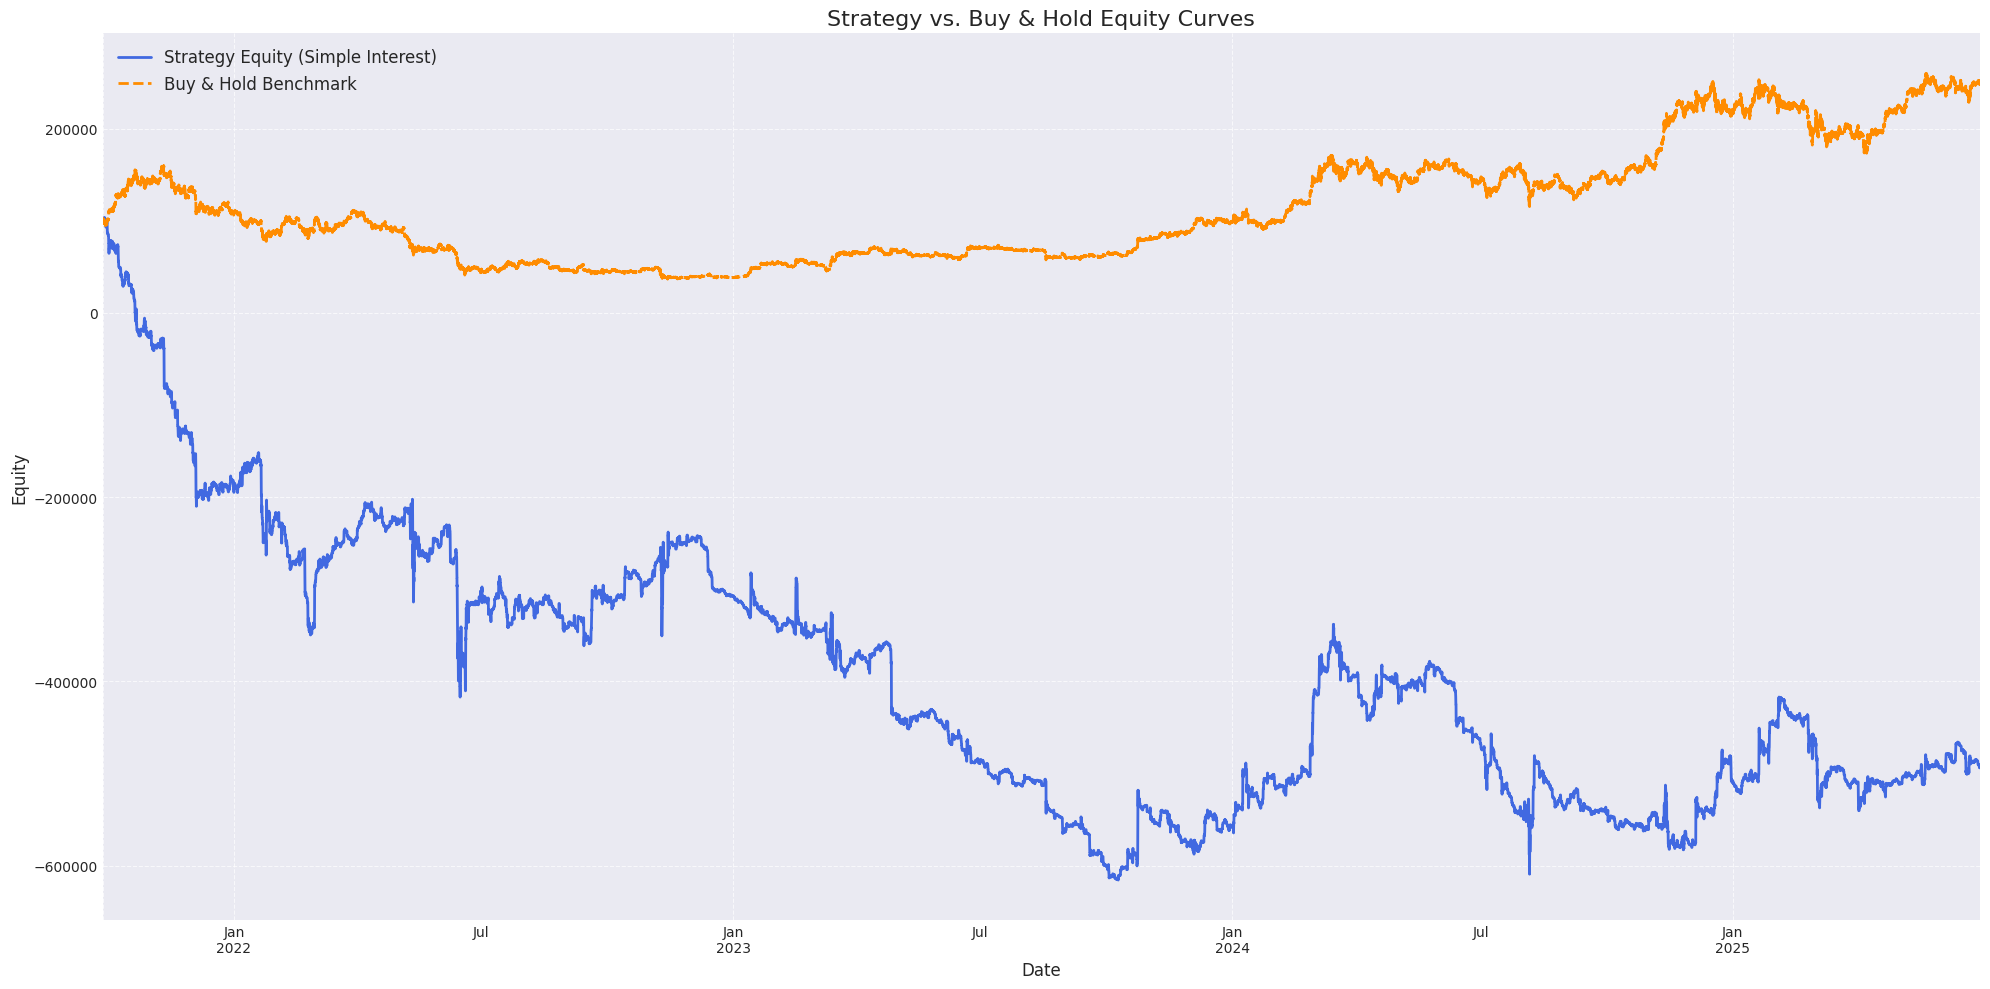

2025-07-23 22:57:30,333 - INFO - 🎊🎊🎊 Strategy evaluation complete 🎊🎊🎊


In [ ]:
if __name__ == '__main__':
    # --- Configuration ---
    # Use Path for better cross-platform compatibility
    FILE_PATH = Path("/public/data/_test_backtest_intern.pkl") # Assuming file is in the same directory
    
    # Backtest Parameters
    HOLDING_PERIOD = 10         # Hold each trade for 10 periods (10 * 15 min)
    COMMISSION_RATE = 0.0002    # Commission per side
    INITIAL_CAPITAL = 100000    # Initial capital
    
    # Model Evaluation Criteria
    EVALUATION_CRITERIA = {
        'sharpe_ratio': 1.0,
        'calmar_ratio': 1.0,
        'expectancy': 0.25,
        'max_drawdown': 0.30, # 30%
        'weekly_frequency': 1
    }

    # --- Step 1: Data Loading ---
    logging.info(f"Loading data from {FILE_PATH}...")
    if not FILE_PATH.exists():
        logging.error(f"❌ FATAL: Data file not found at {FILE_PATH}. Please check the path.")
    else:
        data = pd.read_pickle(FILE_PATH)
        logging.info("✅ Data loaded successfully.")
        logging.info(f"Data shape: {data.shape}")
        logging.info(f"Time range: {data.index.min()} to {data.index.max()}")
        
        # --- Step 2: Run the Backtest ---
        # The 'signal' column from the file is used directly.
        # It already contains the desired positions (1, -1, 0).
        backtest_results, trades_df = run_backtest_independent_trades(
            prices=data['close'],
            signals=data['signal'],
            holding_period=HOLDING_PERIOD,
            initial_capital=INITIAL_CAPITAL,
            commission_rate=COMMISSION_RATE
        )
        
        if not backtest_results.empty:
            # --- 【重要】修正：带教理智检查 (相关性检验) ---
            # 原有的检验逻辑是错误的，现替换为正确的检验逻辑。
            print("\n" + "="*80)
            print(Fore.BLUE + Style.BRIGHT + " " * 25 + "Supervisor's Sanity Check" + " " * 25 + Style.RESET_ALL)
            print("="*80)

            # 1. 获取策略的累计净收益 (基于net_return)
            strategy_cumulative_pnl = backtest_results['cumulative_pnl'].fillna(0)

            # 2. 构建理论上的累计毛收益 (基于gross_return)
            #    这个逻辑和函数内生成净收益曲线的逻辑完全一致
            theoretical_pnl_by_exit_time = trades_df.groupby('exit_time')['gross_return'].sum()
            theoretical_daily_pnl = pd.Series(0.0, index=backtest_results.index)
            theoretical_daily_pnl.update(theoretical_pnl_by_exit_time)
            theoretical_cumulative_gross = theoretical_daily_pnl.cumsum()

            # 3. 对齐索引并计算相关性
            aligned_strategy, aligned_benchmark = strategy_cumulative_pnl.align(theoretical_cumulative_gross, join='inner', fill_value=0)
            
            correlation = 0.0
            if not aligned_strategy.empty and not aligned_benchmark.empty and aligned_strategy.std() > 0 and aligned_benchmark.std() > 0:
                correlation = aligned_strategy.corr(aligned_benchmark)

            print(f"Correlation between cumulative NET PnL and cumulative GROSS PnL: {correlation:.8f}")
            if correlation > 0.999:
                print(Fore.GREEN + "✅ Correlation is extremely high. The commission logic is likely correct." + Style.RESET_ALL)
            else:
                print(Fore.RED + "❌ Correlation is not high. Please check the logic for applying commissions." + Style.RESET_ALL)
            print("="*80 + "\n")


            # --- Step 4: Performance Evaluation ---
            evaluate_performance(
                backtest_results,
                trades_df,
                EVALUATION_CRITERIA,
                INITIAL_CAPITAL
            )